In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py

from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

## Set Parameters

In [2]:
# Parameters
window = int(20*10)
fr_smoothing_window = int(20*0.25)
l2_normalization = True
min_hop_gap = 10
def get_beak_poke(x):
    center_frames = x.hops
    center_frames[np.isin(x.hops, x.event_hops)] = x.event_pokes
    return center_frames

In [3]:
align_events = [
    "Hop Start", "Hop Peak",
    "Hop End", "Beak Poke"
    ]
align_functions = [
    lambda x: x.hop_starts,
    lambda x: x.hops,
    lambda x: x.hop_ends,
    get_beak_poke
    ]
align_population_patterns = {}

## Gather Data

In [4]:
def get_population_patterns(align_func):
    data = {}
    for key in h5_path_dict.keys():
        for fil in range(len(h5_path_dict[key])):
            fil_string = h5_path_dict[key][fil].as_posix()
            f = h5py.File(fil_string, 'r')
            exp_data = ExpData(f, min_hop_gap=min_hop_gap)
            data[fil_string] = {}
            c_hops, r_hops, ch_hops, noncrch_hops = exp_data.get_crch_hops()
            center_frames = align_func(exp_data)
            hop_windows = exp_data.get_hop_windows(window, center_frames)
            fr = get_fr(exp_data.spikes, fr_smoothing_window)
            if l2_normalization:
                scaling = np.square(np.linalg.norm(fr, axis=1))
                fr /= scaling[:, None]
                fr[np.isnan(fr)] = 0
            hop_patterns = np.zeros(
                (hop_windows.shape[0], exp_data.num_neurs, window*2 + 1)
                )
            hop_details = np.zeros((hop_windows.shape[0], 4)) # start, peak, end, len
            for i, hop in enumerate(hop_windows):
                hop_pattern = fr[:, hop]
                hop_pattern[:, hop == -1] = np.nan
                hop_patterns[i] = hop_pattern
                hop_details[i, 0] = exp_data.hop_starts[i] - hop[0]
                hop_details[i, 1] = exp_data.hops[i] - hop[0]
                hop_details[i, 2] = exp_data.hop_ends[i] - hop[0]
                hop_details[i, 3] = exp_data.hop_ends[i] - exp_data.hop_starts[i]
            data[fil_string]['c_hops'] = c_hops
            data[fil_string]['r_hops'] = r_hops
            data[fil_string]['ch_hops'] = ch_hops
            data[fil_string]['noncrch_hops'] = noncrch_hops
            data[fil_string]['fr'] = fr
            data[fil_string]['hop_patterns'] = hop_patterns
            data[fil_string]['hop_times'] = hop_windows
            data[fil_string]['hop_details'] = hop_details
    return data

In [5]:
for event, func in zip(align_events, align_functions):
    align_population_patterns[event] = get_population_patterns(func)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


## Cache v Retrieval of Same Cache

In [6]:
def get_reactiv_vectors(population_patterns):
    cache_reactiv_vectors = []
    retriev_reactiv_vectors = []
    for fil_string in population_patterns.keys():
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f, min_hop_gap=min_hop_gap)
        c_hops = population_patterns[fil_string]['c_hops']
        r_hops = population_patterns[fil_string]['r_hops']
        noncrch_hops = population_patterns[fil_string]['noncrch_hops']
        hop_patterns = population_patterns[fil_string]['hop_patterns']
        hop_times = population_patterns[fil_string]['hop_times']
        hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

        for i, c_hop in enumerate(c_hops):
            c_site = exp_data.event_sites[exp_data.cache_event][i]
            cache_pattern_mat = hop_patterns[c_hop]
            for j, r_hop in enumerate(r_hops):
                if r_hop <= c_hop: continue
                r_site = exp_data.event_sites[exp_data.retriev_event][j]
                if r_site != c_site: continue
                retriev_pattern_mat = hop_patterns[r_hop]
                overlap_matrix = []
                for retriev_pattern in retriev_pattern_mat.T:
                    cache_retriev_overlap = popln_overlap(
                        cache_pattern_mat, retriev_pattern
                        )
                    overlap_matrix.append(cache_retriev_overlap)
                overlap_matrix = np.array(overlap_matrix)
                cache_reactiv_vector = np.nanmean(overlap_matrix, axis=0)
                retriev_reactiv_vector = np.nanmean(overlap_matrix, axis=1)
                cache_reactiv_vectors.append(cache_reactiv_vector)
                retriev_reactiv_vectors.append(retriev_reactiv_vector)
                break
    cache_reactiv_vectors = np.array(cache_reactiv_vectors)
    retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
    return cache_reactiv_vectors, retriev_reactiv_vectors

In [7]:
# Get reactivation patterns for different alignments
cr_reactiv_vectors = {}
for event in align_population_patterns:
    population_patterns = align_population_patterns[event]
    cr_reactiv_vectors[event] = get_reactiv_vectors(population_patterns)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)


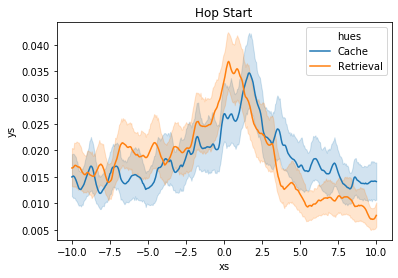

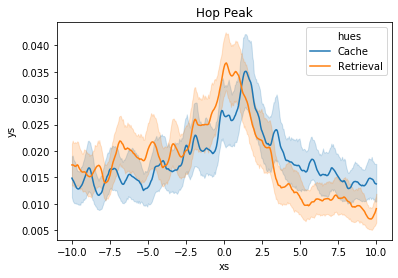

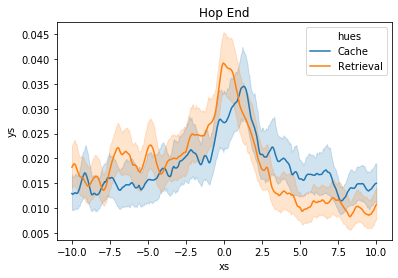

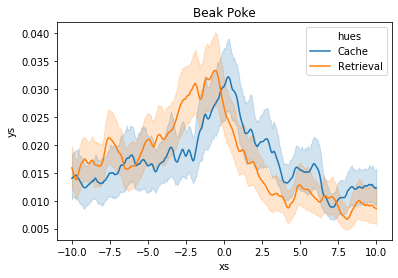

In [17]:
# Plot aligned activity
for event in align_events:
    cache_reactiv_vectors, retriev_reactiv_vectors = cr_reactiv_vectors[event]
    num_hops, num_frames = cache_reactiv_vectors.shape
    xs = np.tile(np.arange(num_frames), (num_hops*2, 1))
    xs = (xs-window)/20
    ys = np.vstack((cache_reactiv_vectors, retriev_reactiv_vectors))
    hues = np.array(num_hops*["Cache"] + num_hops*["Retrieval"])
    hues = np.tile(hues, (num_frames, 1)).T
    df = pd.DataFrame({
        "xs": xs.flatten(), "ys": ys.flatten(), "hues": hues.flatten()
        })
    sns.lineplot("xs", "ys", hue="hues", data=df)
    plt.title(event)
    plt.show()

## Full Check v Cache

In [22]:
def get_reactiv_vectors(population_patterns):
    cache_reactiv_vectors = []
    check_reactiv_vectors = []
    for fil_string in population_patterns.keys():
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f, min_hop_gap=min_hop_gap)
        c_hops = population_patterns[fil_string]['c_hops']
        r_hops = population_patterns[fil_string]['r_hops']
        ch_hops = population_patterns[fil_string]['ch_hops']
        noncrch_hops = population_patterns[fil_string]['noncrch_hops']
        hop_patterns = population_patterns[fil_string]['hop_patterns']
        hop_times = population_patterns[fil_string]['hop_times']
        hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

        for i, c_hop in enumerate(c_hops):
            c_site = exp_data.event_sites[exp_data.cache_event][i]
            cache_pattern_mat = hop_patterns[c_hop]
            for j, ch_hop in enumerate(ch_hops):
                ch_site = exp_data.event_sites[exp_data.check_event][j]
                check_pattern_mat = hop_patterns[ch_hop]
                if not exp_data.cache_present[ch_hop, ch_site-1]: continue
                if c_site != ch_site: continue
                if abs(hop_times[c_hop,0] - hop_times[ch_hop,0]) < 20*5: continue
                overlap_matrix = []
                for check_pattern in check_pattern_mat.T:
                    cache_check_overlap = popln_overlap(
                        cache_pattern_mat, check_pattern
                        )
                    overlap_matrix.append(cache_check_overlap)
                overlap_matrix = np.array(overlap_matrix)
                cache_reactiv_vector = np.nanmean(overlap_matrix, axis=0)
                check_reactiv_vector = np.nanmean(overlap_matrix, axis=1)
                cache_reactiv_vectors.append(cache_reactiv_vector)
                check_reactiv_vectors.append(check_reactiv_vector)
                break
    cache_reactiv_vectors = np.array(cache_reactiv_vectors)
    check_reactiv_vectors = np.array(check_reactiv_vectors)
    return cache_reactiv_vectors, check_reactiv_vectors

In [23]:
# Get reactivation patterns for different alignments
cch_reactiv_vectors = {}
for event in align_population_patterns:
    population_patterns = align_population_patterns[event]
    cch_reactiv_vectors[event] = get_reactiv_vectors(population_patterns)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)


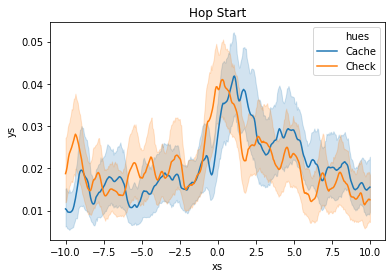

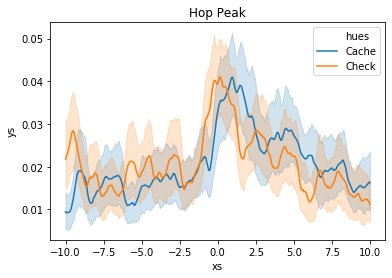

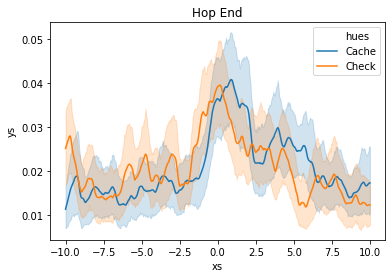

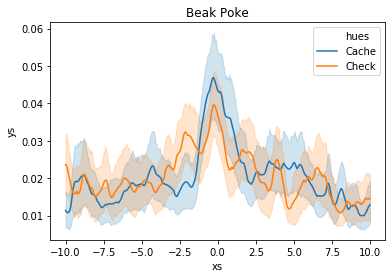

In [24]:
# Plot aligned activity
for event in align_events:
    cache_reactiv_vectors, check_reactiv_vectors = cch_reactiv_vectors[event]
    num_hops, num_frames = cache_reactiv_vectors.shape
    xs = np.tile(np.arange(num_frames), (num_hops*2, 1))
    xs = (xs-window)/20
    ys = np.vstack((cache_reactiv_vectors, check_reactiv_vectors))
    hues = np.array(num_hops*["Cache"] + num_hops*["Check"])
    hues = np.tile(hues, (num_frames, 1)).T
    df = pd.DataFrame({
        "xs": xs.flatten(), "ys": ys.flatten(), "hues": hues.flatten()
        })
    sns.lineplot("xs", "ys", hue="hues", data=df)
    plt.title(event)
    plt.show()

## Full Check v Retrieval

In [17]:
def get_reactiv_vectors(population_patterns):
    retriev_reactiv_vectors = []
    check_reactiv_vectors = []
    for fil_string in population_patterns.keys():
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f, min_hop_gap=min_hop_gap)
        r_hops = population_patterns[fil_string]['r_hops']
        ch_hops = population_patterns[fil_string]['ch_hops']
        noncrch_hops = population_patterns[fil_string]['noncrch_hops']
        hop_patterns = population_patterns[fil_string]['hop_patterns']
        hop_times = population_patterns[fil_string]['hop_times']
        hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

        for i, r_hop in enumerate(r_hops):
            r_site = exp_data.event_sites[exp_data.retriev_event][i]
            retriev_pattern_mat = hop_patterns[r_hop]
            for j, ch_hop in enumerate(ch_hops):
                ch_site = exp_data.event_sites[exp_data.check_event][j]
                check_pattern_mat = hop_patterns[ch_hop]
                if not exp_data.cache_present[ch_hop, ch_site-1]: continue
                if r_site != ch_site: continue
                if abs(hop_times[r_hop,0] - hop_times[ch_hop,0]) < 20*5: continue
                overlap_matrix = []
                for check_pattern in check_pattern_mat.T:
                    retriev_check_overlap = popln_overlap(
                        retriev_pattern_mat, check_pattern
                        )
                    overlap_matrix.append(retriev_check_overlap)
                overlap_matrix = np.array(overlap_matrix)
                retriev_reactiv_vector = np.nanmean(overlap_matrix, axis=0)
                check_reactiv_vector = np.nanmean(overlap_matrix, axis=1)
                retriev_reactiv_vectors.append(retriev_reactiv_vector)
                check_reactiv_vectors.append(check_reactiv_vector)
                break
    retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
    check_reactiv_vectors = np.array(check_reactiv_vectors)
    return retriev_reactiv_vectors, check_reactiv_vectors

In [18]:
# Get reactivation patterns for different alignments
rch_reactiv_vectors = {}
for event in align_population_patterns:
    population_patterns = align_population_patterns[event]
    rch_reactiv_vectors[event] = get_reactiv_vectors(population_patterns)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)


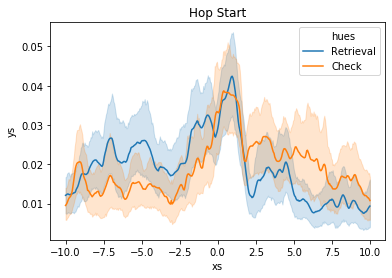

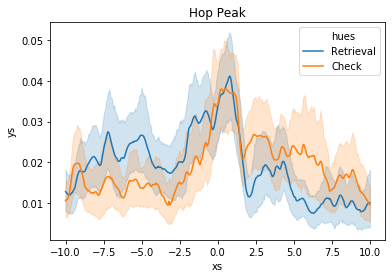

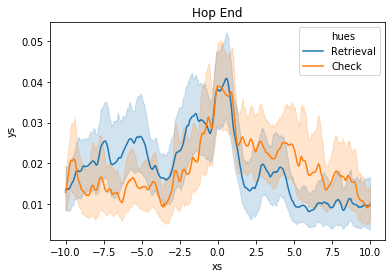

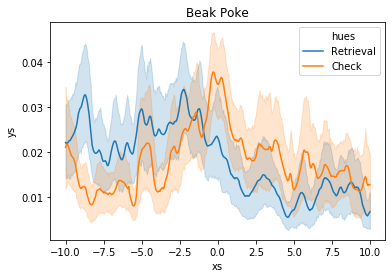

In [19]:
# Plot aligned activity
for event in align_events:
    retriev_reactiv_vectors, check_reactiv_vectors = rch_reactiv_vectors[event]
    num_hops, num_frames = retriev_reactiv_vectors.shape
    xs = np.tile(np.arange(num_frames), (num_hops*2, 1))
    xs = (xs-window)/20
    ys = np.vstack((retriev_reactiv_vectors, check_reactiv_vectors))
    hues = np.array(num_hops*["Retrieval"] + num_hops*["Check"])
    hues = np.tile(hues, (num_frames, 1)).T
    df = pd.DataFrame({
        "xs": xs.flatten(), "ys": ys.flatten(), "hues": hues.flatten()
        })
    sns.lineplot("xs", "ys", hue="hues", data=df)
    plt.title(event)
    plt.show()